# M03. Base Running
- This predicts errors, double plays, out locations, and baserunner advancements
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 12/16/2023
    - Updated: 4/21/2024

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [3]:
run_datasets = False
running_base_runners = True

In [4]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

False


In [5]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Create directory

In [6]:
os.makedirs(os.path.join(model_path, "M04. Base Running", todaysdate), exist_ok=True)

### Dataset

In [7]:
# df2015 = plays_statsapi("04/01/2015", "10/31/2015")
# df2016 = plays_statsapi("04/01/2016", "10/31/2016")
# df2017 = plays_statsapi("04/01/2017", "10/31/2017")
# df2018 = plays_statsapi("04/01/2018", "10/31/2018")
# df2019 = plays_statsapi("04/01/2019", "10/31/2019")
# df2020 = plays_statsapi("04/01/2020", "10/31/2020")
# df2021 = plays_statsapi("04/01/2021", "10/31/2021")
# df2022 = plays_statsapi("04/01/2022", "10/31/2022")
# df2023 = plays_statsapi("04/01/2023", "10/31/2023")
# df2024 = plays_statsapi("04/01/2024", "10/31/2024")

In [8]:
# df = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020, df2021, df2022, df2023, df2024], axis=0)
# df = df.query('game_type == "R"')

In [9]:
# df.to_csv(os.path.join(baseball_path, "Complete Dataset.csv"), index=False)

In [10]:
# Read from CSV
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Complete Dataset.csv"))
# Keep only regular season games
complete_dataset = complete_dataset.query('game_type == "R"')

### Movement Reasons

r_adv_force: advanced on a ball in play because they were forced to <br>
r_adv_play: advanced on a ball in play without being forced to <br>
r_force_out: out on a force play <br>
r_adv_throw: advanced on the throw, not the contact <br>
r_runner_out: out not on a force play <br>
r_thrown_out: out on a hit (base runner) <br>
r_doubled_off: out on a ball caught and thrown to base <br>
r_out_stretching: out on a hit (hitter) <br>

We now have where every runner, including the batter, started and finished. However, we have two problems:
- Some base runners don't move. They are not included in the dataset yet. 
- Some base runners move more than once in a play. They may go from 1B to 2B on a hit and then 2B to 3B on a throw.

### Clean and Create Variables

In [11]:
# Fill in missings
complete_dataset['description'].fillna("Missing", inplace=True)

# Identify errors
complete_dataset['error'] = complete_dataset['description'].str.contains('error', case=False).astype('int')
# Double Play dummy (will be cleaned a bit later)
complete_dataset['double_play'] = complete_dataset['eventType'].isin(['grounded_into_double_play', 'double_play', 'sac_fly_double_play', 'strikeout_double_play', 'sac_bunt_double_play']).astype(int)

# Create bottom half inning dummy
complete_dataset['bottom'] = (complete_dataset['halfInning'] == "bottom").astype('int')

# Determine outs before at bat
complete_dataset['outs_pre'] = complete_dataset.groupby(['gamePk', 'inning', 'bottom'])['outs'].shift(1)
complete_dataset['outs_pre'] = complete_dataset.groupby(['gamePk', 'atBatIndex'])['outs_pre'].transform('min')
complete_dataset['outs_pre'] = np.where(complete_dataset['outs_pre'] == 3, 0, complete_dataset['outs_pre'])

# Fill in missings
complete_dataset['outs_pre'].fillna(0, inplace=True)

### Multiple Movements

Identify where a runner starts and ends in an at bat. Only keep one instance. 

In [12]:
# Determine start and end base by number
# 0 is AB, 1 is 1B, 2 is 2B, 3 is 3B, 4 is scored, 5 is out
complete_dataset['startInt'] = complete_dataset['start'].apply(lambda x: 0 if pd.isna(x) else int(x[0]) if x[0].isdigit() else 0)
complete_dataset['endInt'] = complete_dataset['end'].apply(lambda x: 5 if pd.isna(x) else 4 if x.lower() == 'score' else int(x[0]) if x[0].isdigit() else 0)

In [13]:
complete_dataset['minBase'] = complete_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['startInt'].transform('min')
complete_dataset['maxBase'] = complete_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['endInt'].transform('max')

In [14]:
# Extract the number after "id" using regular expression
complete_dataset['postOnFirst'] = complete_dataset['postOnFirst'].str.extract(r"'id': (\d+)")
complete_dataset['postOnSecond'] = complete_dataset['postOnSecond'].str.extract(r"'id': (\d+)")
complete_dataset['postOnThird'] = complete_dataset['postOnThird'].str.extract(r"'id': (\d+)")

In [15]:
# Determine where runners were to start PA
# Note that the exact id may be incorrect due to pinch runners, but we don't really care.
complete_dataset['preOnFirst'] = complete_dataset.groupby(['gamePk', 'halfInning'])['postOnFirst'].shift(1)
complete_dataset['preOnSecond'] = complete_dataset.groupby(['gamePk', 'halfInning'])['postOnSecond'].shift(1)
complete_dataset['preOnThird'] = complete_dataset.groupby(['gamePk', 'halfInning'])['postOnThird'].shift(1)

# Create a mask to identify the first occurrence of each combination
first_occurrence_mask = ~complete_dataset.duplicated(subset=['gamePk', 'atBatIndex'], keep='first')

# Set 'preOnFirst' to NaN for non-first occurrences
complete_dataset['preOnFirst'] = complete_dataset['preOnFirst'].where(first_occurrence_mask, other=None)
complete_dataset['preOnSecond'] = complete_dataset['preOnSecond'].where(first_occurrence_mask, other=None)
complete_dataset['preOnThird'] = complete_dataset['preOnThird'].where(first_occurrence_mask, other=None)
# Fill in missings
complete_dataset['preOnFirst'] = complete_dataset.groupby(['gamePk', 'atBatIndex'])['preOnFirst'].ffill()
complete_dataset['preOnSecond'] = complete_dataset.groupby(['gamePk', 'atBatIndex'])['preOnSecond'].ffill()
complete_dataset['preOnThird'] = complete_dataset.groupby(['gamePk', 'atBatIndex'])['preOnThird'].ffill()

### Batters

In [16]:
atBat = complete_dataset.query('id == batter')

# Only keep runners at bat
atBat.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

### Runners on 1B

In [17]:
on1B = complete_dataset[~complete_dataset['preOnFirst'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnFirst
on1B['is_runner'] = (on1B['start'] == "1B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on1B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnFirst for instances where there are no runners
on1B.loc[no_runner_mask, 'id'] = on1B.loc[no_runner_mask, 'preOnFirst']
on1B.loc[no_runner_mask, 'runner_id'] = on1B.loc[no_runner_mask, 'preOnFirst']

# Step 4: Create the added_1b column
on1B['added_1b'] = 0
on1B.loc[no_runner_mask, 'added_1b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_1b == 1
on1B.loc[on1B['added_1b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 1
on1B.loc[on1B['added_1b'] == 1, ['start', 'end']] = "1B"

# Step 6: Keep one observation per runner
on1B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on1B = on1B.query('minBase == 1')

### Runners on 2B

In [18]:
on2B = complete_dataset[~complete_dataset['preOnSecond'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnSecond
on2B['is_runner'] = (on2B['start'] == "2B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on2B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnSecond for instances where there are no runners
on2B.loc[no_runner_mask, 'id'] = on2B.loc[no_runner_mask, 'preOnSecond']
on2B.loc[no_runner_mask, 'runner_id'] = on2B.loc[no_runner_mask, 'preOnSecond']

# Step 4: Create the added_2b column
on2B['added_2b'] = 0
on2B.loc[no_runner_mask, 'added_2b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_2b == 1
on2B.loc[on2B['added_2b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 2
on2B.loc[on2B['added_2b'] == 1, ['start', 'end']] = "2B"

# Step 6: Keep one observation per runner
on2B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on2B = on2B.query('minBase == 2')

### Runners on 3B

In [19]:
on3B = complete_dataset[~complete_dataset['preOnThird'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnThird
on3B['is_runner'] = (on3B['start'] == "3B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on3B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preThird for instances where there are no runners
on3B.loc[no_runner_mask, 'id'] = on3B.loc[no_runner_mask, 'preOnThird']
on3B.loc[no_runner_mask, 'runner_id'] = on3B.loc[no_runner_mask, 'preOnThird']

# Step 4: Create the added_3b column
on3B['added_3b'] = 0
on3B.loc[no_runner_mask, 'added_3b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_3b == 1
on3B.loc[on3B['added_3b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 3
on3B.loc[on3B['added_3b'] == 1, ['start', 'end']] = "3B"

# Step 6: Keep one observation per runner
on3B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on3B = on3B.query('minBase == 3')

### Combine

In [20]:
# Concatenate the original DataFrame with the modified rows
df = pd.concat([atBat, on1B, on2B, on3B], axis=0, ignore_index=True)

# Count up observations within an atBatIndex
df['atBatIndexNum'] = df.groupby(['gamePk', 'atBatIndex']).cumcount() + 1

# Sort
df.sort_values(['gamePk', 'atBatIndex', 'atBatIndexNum'], inplace=True)

### Start Locations

In [21]:
# Any runner started on these bases
# Create start location dummies
df['pre_1b'] = (df['minBase'] == 1).astype('int')
df['pre_2b'] = (df['minBase'] == 2).astype('int')
df['pre_3b'] = (df['minBase'] == 3).astype('int')

# Group by 'gamePk' and 'atBatIndex', then use transform to calculate the max for each group
df['pre_1b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_1b'].transform('max')
df['pre_2b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_2b'].transform('max')
df['pre_3b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_3b'].transform('max')

### Fix End Locations

In [22]:
# End locations: Runner
df['post_1b'] = (df['maxBase'] == 1).astype('int')
df['post_2b'] = (df['maxBase'] == 2).astype('int')
df['post_3b'] = (df['maxBase'] == 3).astype('int')

# End locations: At Bat (team)
df['post_1b'] = df.groupby(['gamePk', 'atBatIndex'])['post_1b'].transform('max')
df['post_2b'] = df.groupby(['gamePk', 'atBatIndex'])['post_2b'].transform('max')
df['post_3b'] = df.groupby(['gamePk', 'atBatIndex'])['post_3b'].transform('max')

# End locations: Blocked - this occurs when someone other than the runner is already on a base
# Note: You can't be blocked from advancing to a base you're on or have passed
df['blocked_1b'] = ((df['post_1b'] == 1) & (df['maxBase'] < 1)).astype('int')
df['blocked_2b'] = ((df['post_2b'] == 1) & (df['maxBase'] < 2)).astype('int')
df['blocked_3b'] = ((df['post_3b'] == 1) & (df['maxBase'] < 3)).astype('int')

### Events

In [23]:
# Create game events
df = create_events(df)

# Encode events as integer
df['eventsModelInt'] = df['eventsModel'].map({'b1': 1, 'b2': 2, 'b3': 3, 'hr': 4, 'bb': 5, 'hbp': 6, 'so': 7, 'fo': 8, 'go': 9, 'lo': 10, 'po': 11})

### Out locations

In [24]:
# Determine if a runner is out
df['out'] = (df['maxBase'] == 5).astype('int')

df['out_home'] = ((df['out'] == 1) & (df['minBase'] == 0)).astype('int')
df['out_1b'] = ((df['out'] == 1) & (df['minBase'] == 1)).astype('int')
df['out_2b'] = ((df['out'] == 1) & (df['minBase'] == 2)).astype('int')
df['out_3b'] = ((df['out'] == 1) & (df['minBase'] == 3)).astype('int')

df['out_home'] = df.groupby(['gamePk', 'atBatIndex'])['out_home'].transform('max')
df['out_1b'] = df.groupby(['gamePk', 'atBatIndex'])['out_1b'].transform('max')
df['out_2b'] = df.groupby(['gamePk', 'atBatIndex'])['out_2b'].transform('max')
df['out_3b'] = df.groupby(['gamePk', 'atBatIndex'])['out_3b'].transform('max')

### Cuts

In [25]:
# Drop less relevant events
df = df.query('eventsModel != "Cut"')

In [26]:
# Duplicates (should be very rare. I believe they're mlb's errors, not mine)
df.drop_duplicates(subset=['gamePk', 'atBatIndex', 'minBase'], keep='first', inplace=True)

# Calculate outs in PA
df['outs_calculated'] = df.groupby(['gamePk', 'atBatIndex'])['out'].transform('sum')

# Sometimes, there will be two outs without a double play recorded (typically a pickoff) but we need these for the math to work
df['double_play'] = np.where(df['outs_calculated'] == 2, 1, df['double_play'])
# Sometimes, there will be no outs on a play that's traditionally an out. These are errors.
df['error'] = np.where((df['outs_calculated'] == 0) & (df['eventType'] == 'fielders_choice'), 1, df['error'])

# Drop triple plays
df = df.query('outs_calculated != 3')

In [27]:
# List of typical movement types
movementReason_list = ['r_adv_force', 'r_adv_play', 'r_force_out', 'r_adv_throw', 'r_runner_out', 'r_thrown_out', 'r_doubled_off', 'r_out_stretching']
df['movementTypical'] = df['movementReason'].apply(lambda x: 1 if x in movementReason_list or pd.isna(x) else 0)
# Apply to whole at bat. We'll only keep those for which all movement is typical.
df['movementTypical'] = df.groupby(['gamePk', 'atBatIndex'])['movementTypical'].transform('min')
df = df.query('movementTypical == 1')
df.drop(columns={'movementTypical'}, inplace=True)

In [28]:
# Create dummies
event_dummies = pd.get_dummies(df['eventsModel'], prefix='event').astype(int)
minBase_dummies = pd.get_dummies(df['minBase'], prefix='minBase').astype(int)

# Add event dummies
df = pd.concat([df, event_dummies, minBase_dummies], axis=1)

# Models

### Errors

In [29]:
error_input_list = list(event_dummies.columns) + ['pre_1b', 'pre_2b', 'pre_3b']
# Removed outs_pre because of small sample sizes with specific combinations could lead to high error rates

In [30]:
%%time
# Select relevant columns and handle missing values
X = df.query('startInt == 0')[error_input_list]
y = df.query('startInt == 0')['error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = [
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=1),
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=2),
    MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_errors = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_errors.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_errors.classes_
probability_columns = [f'error_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
error_df = pd.concat([X_test, y_test, probability_df], axis=1)
# error_df['eventsModel'] = label_encoder.inverse_transform(error_df['eventsModelInt'])


# Save model
pickle.dump(predict_errors, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_errors.sav"), 'wb'))

CPU times: total: 4.19 s
Wall time: 1min 28s


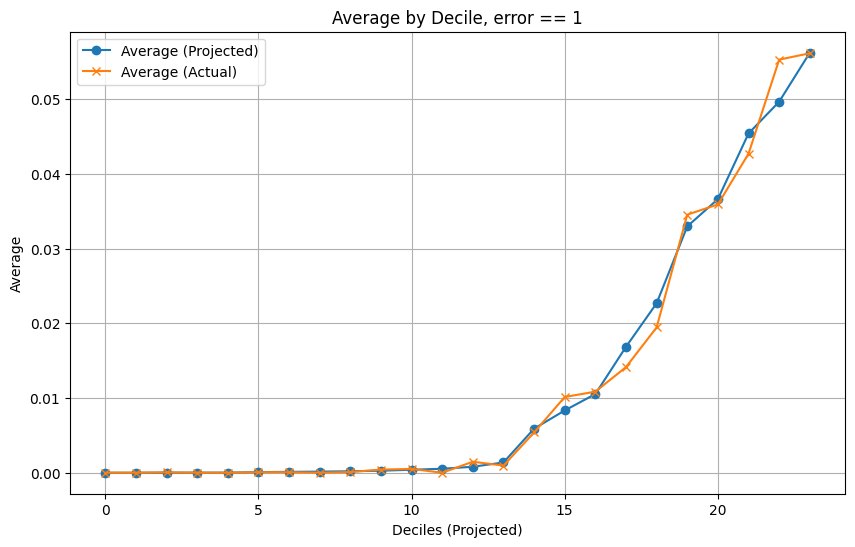

In [31]:
# Set Variable
var = "error"

# Copy 
graph_df = error_df.copy()

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Decile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
error_df[['error_1', 'error']].describe()

,error_1,error
count,334842.0000,334842.0000
mean,0.0126,0.0126
std,0.0171,0.1116
min,0.0000,0.0000
25%,0.0001,0.0000
50%,0.0005,0.0000
75%,0.0331,0.0000
max,0.0577,1.0000


### Double Play

In [33]:
double_play_input_list = list(event_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b']

In [34]:
%%time
# Select relevant columns and handle missing values
X = df.query('minBase == 0')[double_play_input_list] 
y = df.query('minBase == 0')['double_play']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
models = [
    MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=1),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=2),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_dp = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_dp.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_dp.classes_
probability_columns = [f'double_play_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
dp_df = pd.concat([X_test, y_test, probability_df], axis=1)
# events_df['eventsModel'] = label_encoder.inverse_transform(base_df['eventsModelInt'])

# Save model
pickle.dump(predict_dp, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_dp.sav"), 'wb'))

CPU times: total: 5.2 s
Wall time: 1min 38s


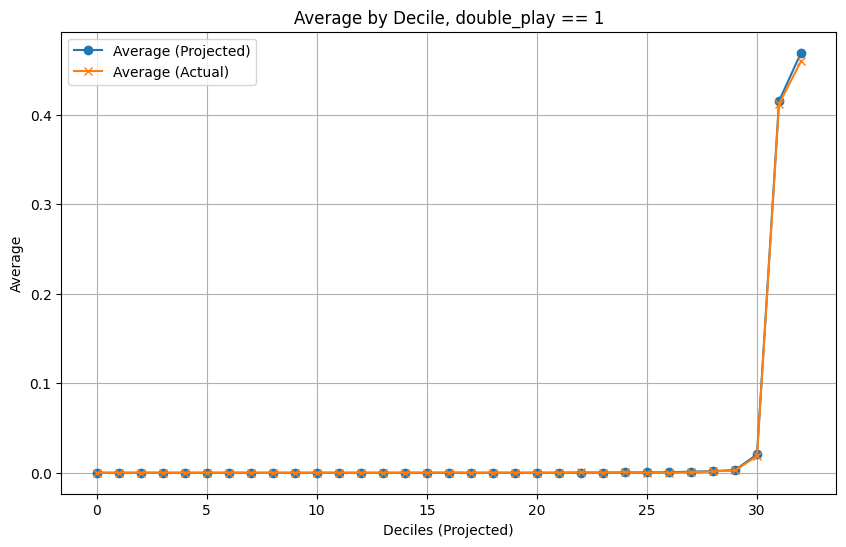

In [35]:
# Set Variable
var = "double_play"

# Copy 
graph_df = dp_df.copy()

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Decile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
dp_df[['double_play_1', 'double_play']].mean()

double_play_1   0.0222
double_play     0.0218
dtype: float64

### Out Bases

In [37]:
out_input_list = list(event_dummies.columns) + list(minBase_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'error', 'double_play']

In [38]:
%%time
# Select relevant columns and handle missing values
X = df[out_input_list] 
y = df['out']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=4),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=5),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=6)
    ]

# Create the ensemble classifier using VotingClassifier
predict_out_bases = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)



# model_out_bases = MLPClassifier(hidden_layer_sizes=(30,30), activation='relu', max_iter=10, random_state=42)
# model_out_bases.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_out_bases.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_out_bases.classes_
probability_columns = [f'out_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
outs_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
pickle.dump(predict_out_bases, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_out_bases.sav"), 'wb'))

CPU times: total: 17.7 s
Wall time: 2min 38s


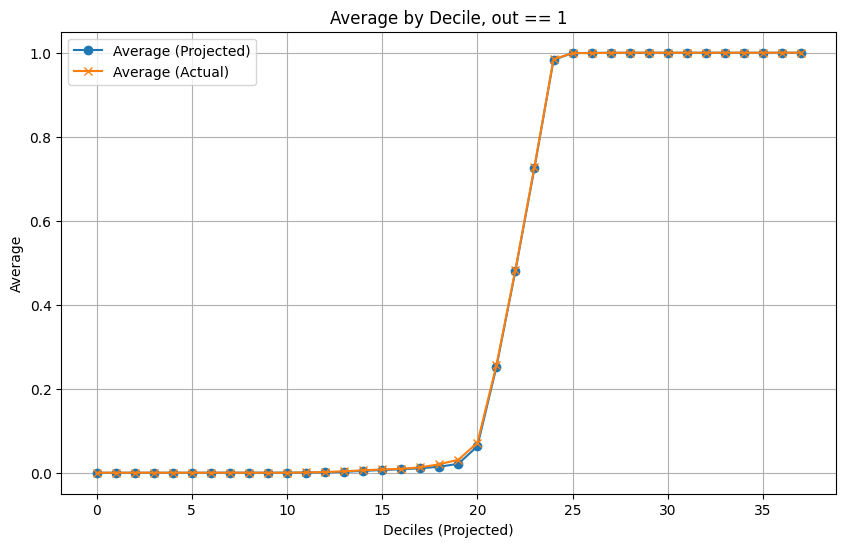

In [39]:
# Set Variable
var = "out"

# Copy 
graph_df = outs_df.copy()

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Decile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
outs_df.query('(event_b1 == 1 or event_b2 == 1 or event_b3 == 1 or event_bb == 1 or event_hbp == 1)')[['out', 'out_1']].mean()

out     0.0078
out_1   0.0057
dtype: float64

In [41]:
outs_df.query('minBase_0 == 1')[['out', 'out_1']].mean()

out     0.6510
out_1   0.6507
dtype: float64

In [42]:
outs_df[['out', 'out_1']].mean()

out     0.4393
out_1   0.4382
dtype: float64

### Base

In [43]:
event_input_list = list(event_dummies.columns) + list(minBase_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'blocked_1b', 'blocked_2b', 'blocked_3b', 'out_home', 'out_1b', 'out_2b', 'out_3b', 'error', 'double_play']

In [44]:
%%time
# Select relevant columns and handle missing values
X = df.query('out == 0')[event_input_list] 
y = df.query('out == 0')['maxBase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create and train the MLPClassifier
# model_events = MLPClassifier(hidden_layer_sizes=(40,), activation='relu', max_iter=10, random_state=2)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=10, random_state=1),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=10, random_state=2),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=10, random_state=3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_events = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_events.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_events.classes_
probability_columns = [f'base_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
events_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
pickle.dump(predict_events, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_events.sav"), 'wb'))

CPU times: total: 4.55 s
Wall time: 36.8 s


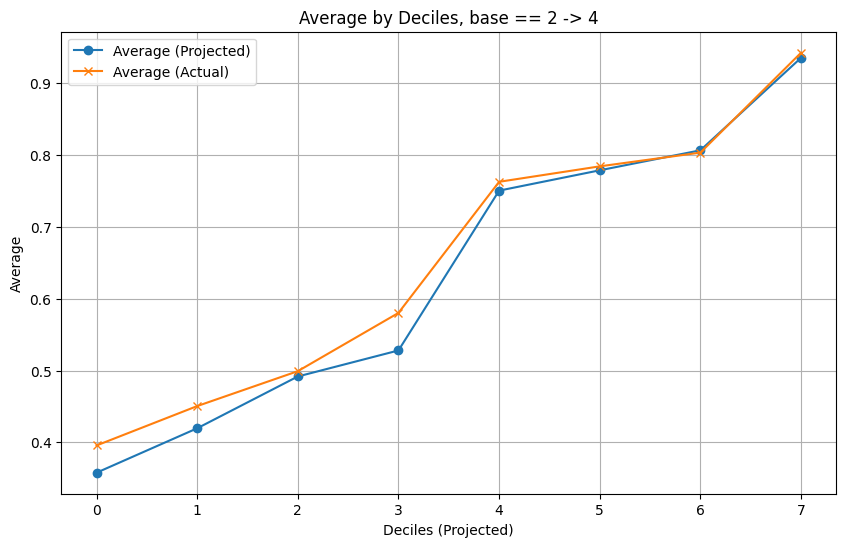

In [45]:
# Set Variables
var = "base"
origin_base = 2
destination_base = 4
event = "b1"
# This one is a little confusing, but it basically shows the probability of ending up at a given base by event type.

# Copy 
graph_df = events_df.copy()
graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_{destination_base}': 'mean', 'base_dummy': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'base_dummy'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Deciles, {var} == {origin_base} -> {destination_base}')
plt.legend()
plt.grid(True)
plt.show()


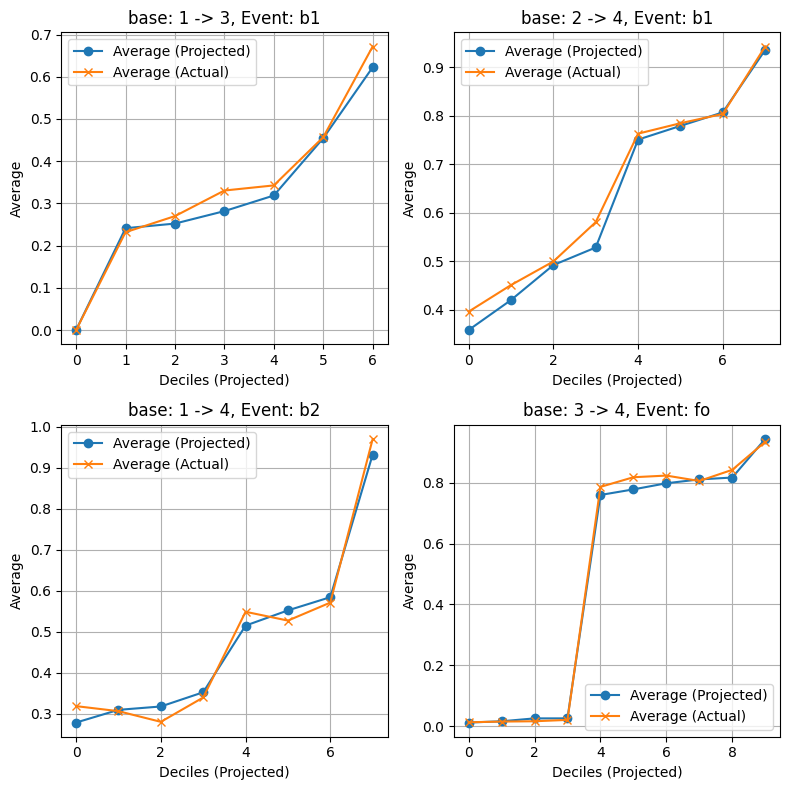

In [52]:
# Define configurations for the 2x2 grid
configs = [
    {"origin_base": 1, "destination_base": 3, "event": "b1"},
    {"origin_base": 2, "destination_base": 4, "event": "b1"},
    {"origin_base": 1, "destination_base": 4, "event": "b2"},
    {"origin_base": 3, "destination_base": 4, "event": "fo"},
]

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

# Iterate through configurations and axes
for i, config in enumerate(configs):
    origin_base = config["origin_base"]
    destination_base = config["destination_base"]
    event = config["event"]
    var = "base"

    # Copy and filter data
    graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
    graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

    # Divide error_1 into deciles
    graph_df['decile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

    # Group by deciles and calculate averages
    grouped_deciles = graph_df.groupby('decile').agg({
        f'{var}_{destination_base}': 'mean', 
        'base_dummy': 'mean'
    }).reset_index()

    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
    ax.plot(grouped_deciles['decile'], grouped_deciles[f'base_dummy'], marker='x', label='Average (Actual)')
    ax.set_title(f'{var}: {origin_base} -> {destination_base}, Event: {event}')
    ax.set_xlabel('Deciles (Projected)')
    ax.set_ylabel('Average')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [46]:
events_df['to_1b'] = (events_df['maxBase'] == 1).astype(int)
events_df['to_2b'] = (events_df['maxBase'] == 2).astype(int)
events_df['to_3b'] = (events_df['maxBase'] == 3).astype(int)
events_df['to_home'] = (events_df['maxBase'] == 4).astype(int)

In [47]:
print(f"2B -> H on a Single: {events_df.query('event_b1 == 1 and minBase_2 == 1')['base_4'].mean()}, {events_df.query('event_b1 == 1 and minBase_2 == 1')['to_home'].mean()}")
print(f"1B -> H on a Double: {events_df.query('event_b2 == 1 and minBase_1 == 1')['base_4'].mean()}, {events_df.query('event_b2 == 1 and minBase_1 == 1')['to_home'].mean()}")
print(f"1B -> 3B on a Single: {events_df.query('event_b1 == 1 and minBase_1 == 1')['base_3'].mean()}, {events_df.query('event_b1 == 1 and minBase_1 == 1')['to_3b'].mean()}")
print(f"3B -> H on a FO: {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['base_4'].mean()}, {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['to_home'].mean()}")

2B -> H on a Single: 0.6153370633858086, 0.6325598172417939
1B -> H on a Double: 0.4296901479226968, 0.42382686950932075
1B -> 3B on a Single: 0.2815742058307932, 0.29695238095238097
3B -> H on a FO: 0.7992482451479678, 0.8190776507686244
